In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

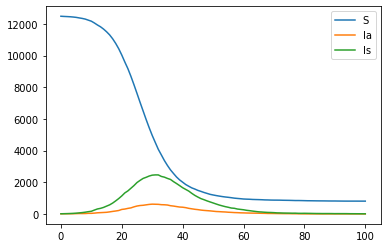

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

In [4]:
# load the data and rescale to intensive variables 
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2116.698339191044
0.3163578510284424


In [5]:
# take a guess 
beta_g = 0.2
gIa_g = 0.01
gIs_g = 0.01
alpha_g = 0.1
guess = [alpha_g, beta_g, gIa_g, gIs_g]

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

343592.96495149675


In [6]:
# inference 

eps = 1e-4 
bounds = [(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)] # give some bounds
start_time = time.time() 
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, 
                                  niter=1, bounds=bounds, 
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

parameters: [0.05103555 0.10202209 0.29917944 0.29917944]
parameters: [0.05215855 0.05112847 0.30372064 0.2943633 ]
parameters: [0.05770506 0.034083   0.30056014 0.29213267]
parameters: [0.0633452  0.02278356 0.29603088 0.28987053]
parameters: [0.0668711  0.01972475 0.29207425 0.28792616]
parameters: [0.09218003 0.01863645 0.25661039 0.26956844]
parameters: [0.15322034 0.01899132 0.16927422 0.2239679 ]
parameters: [0.18426547 0.01912822 0.12169577 0.1974473 ]
parameters: [0.20733104 0.01956097 0.08554697 0.16032874]
parameters: [0.19768086 0.02012966 0.10376877 0.16052293]
parameters: [0.18878011 0.02047932 0.12167766 0.15058168]
parameters: [0.18412946 0.02018951 0.1306729  0.14627255]
parameters: [0.18372733 0.02003383 0.13146445 0.14599316]
parameters: [0.18376541 0.02002746 0.13139939 0.14597958]
basinhopping step 0: f -2115.56
parameters: [0.11508458 0.07281007 0.2339714  0.25518674]
parameters: [0.13153864 0.02424307 0.18639204 0.20509564]
parameters: [0.13855306 0.0162467  0.165

In [7]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2117.1882596430796
0.34780216217041016


In [9]:
hess = estimator.hessian(params, x, Tf, Nf, contactMatrix)
cov = np.linalg.inv(hess)

In [10]:
print(cov)

[[ 3.86709069e-05 -2.04854291e-09  2.84240393e-05 -7.06030807e-06]
 [-2.04854291e-09  1.28901748e-08 -1.29241516e-09  6.58946162e-10]
 [ 2.84240393e-05 -1.29241516e-09  2.67131215e-05 -5.84014409e-06]
 [-7.06030807e-06  6.58946162e-10 -5.84014409e-06  2.27361845e-06]]
